In [1]:
from scipy import io
from scipy.io import wavfile
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import xmltodict
import pandas as pd
import h5py
import pickle
import gc
from matplotlib import mlab
%matplotlib inline

np.random.seed(0)
# plt.ioff()

In [2]:
# traiing data related paths
PATH_TRAIN_IN_16KWAVS = '../data/wav/' # the location where the 16kHz resampled wavs are located
PATH_TRAIN_IN_XMLFILES = '../data/xml/' # the path where the XML meta-data files are located
PATH_TRAIN_OUT_XMLPICKLEFILE = '../data/all_data.pickle' # the location and filename where the XML meta-data will be saved
PATH_TRAIN_OUT_HDF5 = '../data/' # the path where preprocessed data will be saved in HDF5 format
HDF5_FILENAME = 'all_data.hdf5'

# same as above just with test data, the wav related data will be generating in train/predict.py

#M: vvv
# PATH_TEST_IN_XMLFILES = '../birdclef_data/test/xml2016' 
# PATH_TEST_OUT_XMLPICKLEFILE	= '../birdclef_data/test/xml_data.pickle'

In [3]:
# this parameter is used for preprocessing
# the number comes from the following equation: np.floor(sampling_frequency/(FFT_length-FFT_overlap))*num_of_seconds
# we use 16kHz sampling rate for the wavs, 512 FFT window length with 256 overlap and we investigate 5 seconds 
spectrogramWindowLength = int(5*np.floor(16000/(512-256))); 

In [4]:
# function to load corresponding XML files into a Pandas dataframe
def readXMLs(xmldirpath):
    df = pd.DataFrame()
    for path, subdirs, files in os.walk(xmldirpath):
        for name in files:
            #M: print(os.path.join(path, name))
            if (name.endswith('.xml')):
                print(os.path.join(path, name))
                #M: tempXmlFile = open(os.path.join(path, name), 'rb')
                tempXmlFile = open(os.path.join(path, name), 'r', encoding="utf-8") #M:
                metadata = tempXmlFile.readlines()
                tempXmlFile.close()
                #M: print(type(metadata),metadata) #M: debug
                df = df.append(pd.DataFrame(xmltodict.parse(''.join(metadata))['Audio'], index=['0'])).reset_index(drop=True)
    return df

In [5]:
# function to merge meta-data of the XML file
def mergeOFGS(row):
    return "{}  {} {} {}".format(row["Order"], row["Family"], row["Genus"], row["Species"])

In [6]:
# if 'x' array contains 1, this expands it inthe given directions
# used for the mask applied to the spectogram
def expandOnes(x, directions = [[-1,0], [1,0], [0,-1], [0,1]]):
    expand = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if (x[i,j] == 1):
                for direction in directions:
                    cx = i + direction[0]
                    cy = j + direction[1]
                    if (0 <= cx < x.shape[0] and 0 <= cy < x.shape[1]):
                        expand[cx,cy]=1;
    return x+expand;

### vvvvv 在部份蛙音原始檔裡會出現導致 np.1og10 裡有 0 的情況產生, 而產生負無窮大的值, 故改成 +1 vvvvv

In [7]:
# function to filter the spectogram based on the energy of the signal
#
# parameters:
#   data: audio data
#   expandByOne: if it is True, than the mask of the spectogram will be expanded in every direction
#   dropZeroColumnsPercent: determines the ratio of 0 values along the frequency axis when a timeslice is dropped
#
# return values:
#   spectogram
#   filtered spectogram

def audioToFilteredSpectrogram(data, expandByOne = True, dropZeroColumnsPercent = 0.95):
    # calculate the spectogram
    
    #
    #tempSpec = np.log10(mlab.specgram(data, NFFT=512, noverlap=256, Fs=16000)[0])
    tempSpec = np.log10(mlab.specgram(data, NFFT=512, noverlap=256, Fs=16000)[0]+1)

    # drop higher frequencies
    tempSpec = tempSpec[0:200,:]
    tempSpecFiltered = np.copy(tempSpec)

    # we analize the spectogram by 20x30 sized cells
    # to achieve better accuray the size of this cell should be finetuned
    rowBorders = np.ceil(np.linspace(0,tempSpec.shape[0], 20))
    columnBorders = np.hstack((np.ceil(np.arange(0,tempSpec.shape[1], 30)), tempSpec.shape[1]))
    rowBorders = [ int(x) for x in rowBorders ]
    columnBorders = [ int(x) for x in columnBorders ]
    keepCells = np.ones((len(rowBorders)-1, len(columnBorders)-1))

    # we create a mask for the spectogram: we scan the spectogram with the 20x30 sized
    # cell and create 0 mask based on the mean and std of the spectogram calculated for the cells and rows
    for i in range(len(rowBorders)-1):
        row_mean = np.mean(tempSpec[rowBorders[i]:rowBorders[i+1],:])
        row_std = np.std(tempSpec[rowBorders[i]:rowBorders[i+1],:])

        for j in range(len(columnBorders)-1):
            cell_mean = np.mean(tempSpec[rowBorders[i]:rowBorders[i+1],columnBorders[j]:columnBorders[j+1]])
            cell_max_top10_mean = np.mean(np.sort(tempSpec[rowBorders[i]:rowBorders[i+1],columnBorders[j]:columnBorders[j+1]], axis=None)[-10:])

            if (cell_mean < 0 or ((cell_max_top10_mean) < (row_mean + row_std)*1.5)):
                keepCells[i,j]=0

    # expand by ones (see above)
    if expandByOne:
        keepCells = expandOnes(keepCells)

    # apply the mask to the spectogram
    for i in range(keepCells.shape[0]):
        for j in range(keepCells.shape[1]):
            if not keepCells[i,j]:
                tempSpecFiltered[rowBorders[i]:rowBorders[i+1],columnBorders[j]:columnBorders[j+1]] = 0

    # drop zero columns
    # the amount of zero values along axis 0 (frequency) is calculated for every column (timeslice)
    # and it is dropped, if the number of zero values is higher than the dropZeroColumnsPercent 
    # eg. dropZeroColumnsPercent=0.95, than a column (timeslice) is dropped, if more than 95% of the values (frequencies) is 0
    tempSpecFilteredBackup = np.copy(tempSpecFiltered)
    tempSpecFiltered = np.delete(tempSpecFiltered, np.nonzero((tempSpecFiltered==0).sum(axis=0) > tempSpecFiltered.shape[0]*dropZeroColumnsPercent), axis=1)

    # if every row was 0 than use the backed up spectogram
    if tempSpecFiltered.shape[1] == 0:
        tempSpecFiltered = tempSpecFilteredBackup

    return tempSpec, tempSpecFiltered;

In [8]:
# function to return most common classes in the dataset
def getMostCommon(df, N=10):
    from collections import Counter
    c = Counter(df["ClassId"])
    mostCommon = c.most_common(N)
    df_mostCommon = pd.DataFrame()
    for item in mostCommon:
        df_mostCommon = df_mostCommon.append(df[df["ClassId"] == item[0]], ignore_index=True)
    df_mostCommon.reset_index(drop=True)
    return df_mostCommon;

In [9]:
# function to return data inbetween minQuality and maxQuality
def filterByQuality(df, minQuality=0, maxQuality=5):
    df_filtered = pd.DataFrame()
    for quality in range(minQuality, maxQuality+1):
        df_filtered = df_filtered.append(df[df["Quality"] == str(quality)], ignore_index=True)
    df_filtered.reset_index(drop=True, inplace=True)
    return df_filtered;   

In [10]:
# function to remove samples where background species exist
def removeSamplesWithBackgroundSpecies(df):
    return df[df.BackgroundSpecies.isnull()]

In [11]:
# create onehot encoding for order, family, genus, specie
def getOneHotOFGS(df):
    from sklearn.preprocessing import LabelBinarizer
    lb = LabelBinarizer()
    lb.fit(df["OFGS"])
    return ( lb, lb.transform(df["OFGS"]) )

In [12]:
# create onehot encoding for classid
def getOneHotClassId(df):
    from sklearn.preprocessing import LabelBinarizer
    lb = LabelBinarizer()
    lb.fit(df["ClassId"])
    return ( lb, lb.transform(df["ClassId"]) )

In [13]:
# bulk processing of wav files in path
#
# parameters:
#   path        the source path
#   filenames   the filenames in the path
#   dontFilter  does not filter the spectogram if it is set to True
#
# return value:
#   specotogram data of multiple files

def wavsToSpectrogramByList(path, filenames, dontFilter=False):
    print("wavsToSpectrogramByList...")
    data=list()
    for filename in filenames:
        print('\r    Processing {}'.format(os.path.join(path, filename))),
        (tempSpecUnfiltered,tempSpecFiltered) = audioToFilteredSpectrogram(io.wavfile.read(os.path.join(path, filename))[1], expandByOne=True)
        if (not dontFilter):
            data.append(tempSpecFiltered)
        else:
            data.append(tempSpecUnfiltered)
    print("\nwavsToSpectrogramByList finished")
    return data;

In [14]:
# function to create training data from the list generated by wavsToSpectogramByList function
#
# parameters:
#   slist      the spectogram list generated by wavsToSpectogramByList function
#   labels     contain the class labels of the corresponding spectograms
#   N          (1*44100)/(1024-512)=86
#   filenames  filenames to return
#   classIds   class IDs to return
#
# return values
#   X          the constructed input
#   y          the constructed output
#   fn         filenames
#   cIds       class IDs
#
  
def spectrogramListToT4(slist, labels=None, N=spectrogramWindowLength, filenames=None, classIds=None): 
    print("SpectrogramListToT4...")

    rows = len(slist[0])
    X = np.empty((0,1,rows,N))
    y = []
    fn = []
    cIds = []

    # process all spectograms
    for i in range(len(slist)):
        print('\r    Processing no. %d / %d' % (i, len(slist)))
        ranges = np.hstack((np.arange(0, len(slist[i][0]), N), len(slist[i][0])))

        for j in range(len(ranges)-1):
            # variable contains
            tempSpec = np.empty((1,rows,N))

            if (len(slist[i][0]) < N): # if data is shorter than N than fill up with zeros
                tempSpec[0] = np.hstack((slist[i],np.zeros((rows, N-len(slist[i][0])))))
            elif (ranges[j+1]-ranges[j] < N): # last element
                tempSpec[0] = slist[i][:,-N:]
            else: # other part of the spectrum
                tempSpec[0] = slist[i][:,ranges[j]:ranges[j+1]]
                
            #M: for debug
            #M:print('   Shape of tempSpec={}'.format(tempSpec.shape))
            #M:output is: Shape of tempSpec=(1, 200, 310) # channel_first

            X = np.vstack((X,[tempSpec]))

            if labels is not None:
                y.append(labels[i])
            if filenames is not None:
                fn.append(filenames[i])
            if classIds is not None:
                cIds.append(classIds[i])

    print("SpectrogramListToT4 finished")
    return X, y, fn, cIds

In [15]:
# calculates the standard scaler coefficients of the input data for 0 mean and 1 variance
#
# parameters
#   numberOfFiles   the number of files to process (we assume that the mean and variance will be similar in case
#                   of a subset of the training data and we don't have to process the whole database
#   wavdirpath      the path that contains the wavs (sampled at 16kHz)
#   xmlpicklepath   the path and filename that contains the XML file for training (xml_data.pickle)
#
# return values
#   scaler
#   spectogramData
#

def generateScaler(numberOfFiles=100, wavdirpath=PATH_TRAIN_IN_16KWAVS, xmlpicklepath=PATH_TRAIN_OUT_XMLPICKLEFILE, todirrootpath=PATH_TRAIN_OUT_HDF5):
    if not os.path.exists(todirrootpath):
        os.makedirs(todirrootpath)

    import pickle    
    df = pd.read_pickle(xmlpicklepath) # contains the metadata
    print("Metadata loaded")

    # Shuffle rows
    df = df.iloc[np.random.permutation(len(df))]
    df.reset_index(drop=True, inplace=True)
    print("Metadata shuffled")
    
    # Calculate spectograms
    spectrogramData = wavsToSpectrogramByList(wavdirpath, df.FileName[:numberOfFiles], dontFilter=False)
    print("Spectrograms done.")

    print('Building scaler...')
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    # calculate the scaler variables spectogram by spectogram
    for sData in spectrogramData:
        scaler.partial_fit(sData.reshape(-1,1))

    # filename where we save the scaler
    saveTo = os.path.join(todirrootpath,"standardScaler_{}.pickle".format(numberOfFiles))
    from sklearn.externals import joblib
    import pickle
    pickle.dump(scaler, open(saveTo, 'wb'))
    print('Scaler saved to: {}'.format(saveTo))
    
    return scaler, spectrogramData

In [16]:
# function that constructs training data 
#
# parameters:
#   N                   number of most classes to take into account 
#   wavdirpath          path of the wave files (16kHz)
#   xmlpicklepath       the path and filename that contains the XML file for training (xml_data.pickle)
#   todirrootpath       path were to save the training data
#
# return values:
#   X,y,fn              for debuging purposes
#

def processNMostCommon(N=3, wavdirpath=PATH_TRAIN_IN_16KWAVS, xmlpicklepath=PATH_TRAIN_OUT_XMLPICKLEFILE, todirrootpath=PATH_TRAIN_OUT_HDF5):
    global spectrogramWindowLength

    if not os.path.exists(todirrootpath):
        os.makedirs(todirrootpath)

    spectrogramHeight = 200

    #f = h5py.File(os.path.join(todirrootpath,"data_top{}_nozero.hdf5".format(N)), "w")
    f = h5py.File(os.path.join(todirrootpath, HDF5_FILENAME), "w")
    dsetX = f.create_dataset('X', (0,1,spectrogramHeight,spectrogramWindowLength), maxshape=(None, 1,spectrogramHeight,spectrogramWindowLength))
    dsety = f.create_dataset('y', (0,N), maxshape=(None,N))
    dsetMediaId = f.create_dataset('MediaId', (0,1), maxshape=(None,1))
#M:    dsetClassId = f.create_dataset('ClassId', (0,1), maxshape=(None,1), dtype=h5py.special_dtype(vlen=unicode))
    dsetClassId = f.create_dataset('ClassId', (0,1), maxshape=(None,1), dtype=h5py.special_dtype(vlen=str))
    
    import pickle    
    df = pd.read_pickle(xmlpicklepath) # read the metadata

    # if we would like to keep recordings with a given quality than we can do it here by uncommenting the next line
    #df = filterByQuality(df, 0, 3)

    df["OFGS"] = df.apply(mergeOFGS, axis=1) # merge Order, Family, Genus, Species
    df_mc = getMostCommon(df, N) # get N most common classes from the dataset
    df = None # let GC free up some memory
    print("Metadata loaded")

    # Shuffle rows
    df_mc = df_mc.iloc[np.random.permutation(len(df_mc))]
    df_mc.reset_index(drop=True, inplace=True)
    (lb,binaryLabels) = getOneHotClassId(df_mc) # generate one-hot labels
    pickle.dump(lb, open(os.path.join(todirrootpath,"labelBinarizer_top{}.pickle".format(N)), 'wb'))

    # process the selected files of top N classes and save the data into HDF5
    fileRanges = np.hstack((np.arange(0, len(df_mc), 30), len(df_mc)))
    for i in range(len(fileRanges)-1):
        tempSG = wavsToSpectrogramByList(wavdirpath, df_mc.FileName[fileRanges[i]: fileRanges[i+1]], dontFilter=False)
        X, y, fn, cIds = spectrogramListToT4(tempSG, \
                            binaryLabels[fileRanges[i]: fileRanges[i+1]], \
                            filenames = df_mc.MediaId[fileRanges[i]: fileRanges[i+1]].values, N=spectrogramWindowLength, \
                            classIds = df_mc.ClassId[fileRanges[i]: fileRanges[i+1]].values) #convert to t4
        pre_len = dsetX.shape[0]
        add_len = X.shape[0]
        dsetX.resize(pre_len+add_len, axis=0)
        dsety.resize(pre_len+add_len, axis=0)
        dsetMediaId.resize(pre_len + add_len, axis=0)
        dsetClassId.resize(pre_len + add_len, axis=0)
        dsetX[pre_len:pre_len+add_len,:,:,:] = X
        dsety[pre_len:pre_len+add_len,:] = y
        dsetMediaId[pre_len:pre_len+add_len,:] = np.transpose([[int(i) for i in fn]])
        dsetClassId[pre_len:pre_len+add_len,:] = np.transpose([[s.encode('utf8') for s in cIds]])
        f.flush()
        
    f.close
    return (X,y,fn) # return last batch for debug purposes

In [17]:
print("== Generating training data ....==")
print("Reading XML files and generating pickle file for all...")
df_xml = readXMLs(PATH_TRAIN_IN_XMLFILES) # read XML files with meta-data
df_xml.to_pickle(PATH_TRAIN_OUT_XMLPICKLEFILE) # save the loaded meta-data into a pickle file with all the informatio

== Generating training data ....==
Reading XML files and generating pickle file for all...
../data/xml/蘭嶼角鴞_ML42142 蘭嶼角鴞.xml
../data/xml/白耳畫眉_ML14163 白耳畫眉.xml
../data/xml/深山鶯_XC176813 - 深山鶯〔黃腹樹鶯〕 - Horornis acanthizoides.xml
../data/xml/蘭嶼角鴞_ML42188 蘭嶼角鴞.xml
../data/xml/諸羅樹蛙_13497514601bcg-l.xml
../data/xml/蘭嶼角鴞_ML42116 蘭嶼角鴞.xml
../data/xml/諸羅樹蛙_13497512751t7b-l.xml
../data/xml/黑臉鵐_ML77298151 黑臉鵐.xml
../data/xml/朱鸝_XC112363 - 朱鸝 - Oriolus traillii ardens.xml
../data/xml/紅尾伯勞_ML89553891 紅尾伯勞(灰頭).xml
../data/xml/日本樹蛙_13417346121m2z-l.xml
../data/xml/野鴝_ML45017221 野鴝.xml
../data/xml/大彎嘴_13402442091x5p-l 大彎嘴 Pomatorhinus erythrocnemis.xml
../data/xml/粉紅鸚嘴_ML14231 粉紅鸚嘴.xml
../data/xml/極北柳鶯_XC403580 - 極北柳鶯 - Phylloscopus borealis borealis.xml
../data/xml/諸羅樹蛙_13497518051uoj-l.xml
../data/xml/史丹吉氏小雨蛙_134967581911rr-l.xml
../data/xml/繡眼畫眉_ML28856611 繡眼畫眉.xml
../data/xml/台灣叢樹鶯_ML25650441 台灣叢樹鶯.xml
../data/xml/蘭嶼角鴞_ML42179 蘭嶼角鴞.xml
../data/xml/冠羽畫眉_ML108057 冠羽畫眉.xml
../data/xml/金線蛙_1386832275118

../data/xml/繡眼畫眉_ML88156 繡眼畫眉.xml
../data/xml/紅尾伯勞_ML27768021 紅尾伯勞(灰頭).xml
../data/xml/黃眉柳鶯_ML26571541 黃眉柳鶯.xml
../data/xml/極北柳鶯_ML38238241 極北柳鶯.xml
../data/xml/台灣叢樹鶯_ML90412451 台灣叢樹鶯.xml
../data/xml/黃眉柳鶯_ML77286451 黃眉柳鶯.xml
../data/xml/黃眉柳鶯_XC394970 - 黃眉柳鶯 - Phylloscopus inornatus.xml
../data/xml/黃山雀_ML108054 黃山雀.xml
../data/xml/叉尾太陽鳥_ML59158171 叉尾太陽鳥.xml
../data/xml/白頭翁_1322639551-l 白頭翁 Pycnonotus sinensis formosae.xml
../data/xml/灰頭鷦鶯_ML89102351 灰頭鷦鶯.xml
../data/xml/蘭嶼角鴞_XC281841 - 蘭嶼角鴞〔優雅角鴞〕 - Otus elegans botelensis.xml
../data/xml/白環鸚嘴鵯_XC406681 - 白環鸚嘴鵯〔領雀嘴鵯〕 - Spizixos semitorques.xml
../data/xml/黑臉鵐_ML22820751 黑臉鵐.xml
../data/xml/深山鶯_XC34185 - 深山鶯〔黃腹樹鶯〕 - Horornis acanthizoides concolor.xml
../data/xml/綠繡眼_XC407038 - 暗綠繡眼〔東亞綠繡眼，綠繡眼〕 - Zosterops japonicus simplex.xml
../data/xml/小啄木_XC207259 - 小啄木〔星頭啄木〕 - Dendrocopos canicapillus kaleensis.xml
../data/xml/翠鳥_XC357710 - 普通翠鳥 - Alcedo atthis bengalensis.xml
../data/xml/小彎嘴_XC89912 - 小彎嘴〔臺灣鉤嘴鶥〕 - Pomatorhinus musicus.xml
../data/xm

../data/xml/蘭嶼角鴞_ML42119 蘭嶼角鴞.xml
../data/xml/五色鳥_ML61771911 五色鳥.xml
../data/xml/褐頭鷦鶯_ML87383841 褐頭鷦鶯.xml
../data/xml/黃尾鴝_ML20781461 黃尾鴝.xml
../data/xml/叉尾太陽鳥_ML59046741 叉尾太陽鳥.xml
../data/xml/紅嘴黑鵯_ML92345091 紅嘴黑鵯.xml
../data/xml/紅尾伯勞_XC62712 - 紅尾伯勞 - Lanius cristatus.xml
../data/xml/黃眉柳鶯_ML39213691 黃眉柳鶯.xml
../data/xml/頭烏線_XC188358 - 頭烏線〔褐頂雀鶥〕 - Alcippe brunnea brunnea.xml
../data/xml/白頭翁_ML90222571 白頭翁.xml
../data/xml/小桑鳲_ML55816871 小桑鳲.xml
../data/xml/赤腹山雀_ML87382871 赤腹山雀.xml
../data/xml/盤古蟾蜍_134173559418yi-l (1).xml
../data/xml/深山鶯_ML62266871 深山鶯.xml
../data/xml/大赤啄木_XC34278 - 大赤啄木〔白背啄木〕 - Dendrocopos leucotos insularis.xml
../data/xml/白環鸚嘴鵯_ML90520801 白環鸚嘴鵯.xml
../data/xml/野鴝_ML77286511 野鴝.xml
../data/xml/樹鵲_ML13491 樹鵲.xml
../data/xml/紋翼畫眉_XC62887 - 紋翼畫眉〔臺灣斑翅鶥〕 - Actinodura morrisoniana.xml
../data/xml/白耳畫眉_ML14166 白耳畫眉.xml
../data/xml/噪鵑_ML59754581 噪鵑.xml
../data/xml/黃胸藪眉_XC375591 - 黃胸藪鶥〔黃痣藪鶥，藪鳥〕 - Liocichla steerii.xml
../data/xml/紅嘴黑鵯_ML90060321 紅嘴黑鵯.xml
../data/xml/繡眼畫眉_ML90222

../data/xml/灰頭鷦鶯_ML90072181 灰頭鷦鶯.xml
../data/xml/褐鷽_XC206962 - 褐鷽〔褐灰雀〕 - Pyrrhula nipalensis uchidai.xml
../data/xml/繡眼畫眉_ML90944331 繡眼畫眉.xml
../data/xml/山紅頭_XC65421 - 山紅頭〔紅頭穗鶥〕 - Stachyridopsis ruficeps praecognita.xml
../data/xml/南亞夜鷹_XC187727 - 林夜鷹〔南亞夜鷹〕 - Caprimulgus affinis stictomus.xml
../data/xml/小啄木_XC403577 - 小啄木〔星頭啄木〕 - Dendrocopos canicapillus.xml
../data/xml/頭烏線_ML90547251 頭烏線.xml
../data/xml/灰頭鷦鶯_ML58794091 灰頭鷦鶯.xml
../data/xml/冠羽畫眉_XC234373 - 冠羽畫眉〔褐頭鳳鶥，臺灣鳳鶥〕 - Yuhina brunneiceps.xml
../data/xml/野鴝_ML55422621 野鴝.xml
../data/xml/栗背林鴝_13402438661neg-l 栗背林鴝 Tarsiger johnstoniae.xml
../data/xml/栗背林鴝_XC278275 - 栗背林鴝〔臺灣林鴝〕 - Tarsiger johnstoniae.xml
../data/xml/腹斑蛙_13704895581qbf-l.xml
../data/xml/小卷尾_ML90415351 小卷尾.xml
../data/xml/野鴝_ML39498821 野鴝.xml
../data/xml/灰頭鷦鶯_ML86861121 灰頭鷦鶯.xml
../data/xml/綠啄花_XC48083 - 綠啄花〔純色啄花〕 - Dicaeum minullum uchidai.xml
../data/xml/褐頭花翼_XC278138 - 褐頭花翼〔臺灣雀鶥，紋喉雀鶥〕 - Fulvetta formosana.xml
../data/xml/極北柳鶯_XC282875 - 極北柳鶯 - Phylloscopus borealis

../data/xml/白頭翁_ML65334571 白頭翁.xml
../data/xml/頭烏線_ML59673931 頭烏線.xml
../data/xml/黃尾鴝_XC154403 - 黃尾鴝〔北紅尾鴝〕 - Phoenicurus auroreus.xml
../data/xml/中國畫眉_ML37004021 大陸畫眉.xml
../data/xml/小鶯_ML82316001 小鶯.xml
../data/xml/黃胸藪眉_XC206981 - 黃胸藪鶥〔黃痣藪鶥，藪鳥〕 - Liocichla steerii.xml
../data/xml/翡翠樹蛙_13517715981kbr-l.xml
../data/xml/茶腹鳾_ML14761 茶腹鳾.xml
../data/xml/台灣鷦眉_13532939501p91-l 臺灣鷦眉 Pnoepyga formosana.xml
../data/xml/黑枕藍鶲_XC406628 - 黑枕藍鶲〔黑枕王鶲〕 - Hypothymis azurea.xml
../data/xml/灰頭鷦鶯_XC62064 - 灰頭鷦鶯 - Prinia flaviventris sonitans.xml
../data/xml/小彎嘴_ML90411951 小彎嘴.xml
../data/xml/白頷樹蛙_1322146587-l.xml
../data/xml/大卷尾_ML56963951 大卷尾.xml
../data/xml/黃眉柳鶯_ML48082821 黃眉柳鶯.xml
../data/xml/領角鴞_XC116602 - 領角鴞 - Otus lettia glabripes.xml
../data/xml/赤腹山雀_XC403525 - 赤腹山雀〔雜色山雀〕 - Sittiparus varius castaneoventris.xml
../data/xml/五色鳥_ML90547001 五色鳥.xml
../data/xml/小翼鶇_XC34155 - 小翼鶇〔藍短翅鶇〕 - Brachypteryx montana goodfellowi.xml
../data/xml/小彎嘴_ML38740311 小彎嘴.xml
../data/xml/紅胸啄花_ML14791 紅胸啄花.xml
../data/xm

../data/xml/繡眼畫眉_ML90528281 繡眼畫眉.xml
../data/xml/貢德氏赤蛙_13781794021nxz-l.xml
../data/xml/紅胸啄花_ML90943591 紅胸啄花.xml
../data/xml/白環鸚嘴鵯_ML65833021 白環鸚嘴鵯.xml
../data/xml/褐頭鷦鶯_ML90541481 褐頭鷦鶯.xml
../data/xml/大卷尾_ML90413381 大卷尾.xml
../data/xml/台灣叢樹鶯_ML25455751 台灣叢樹鶯.xml
../data/xml/小彎嘴_XC284415 - 小彎嘴〔臺灣鉤嘴鶥〕 - Pomatorhinus musicus.xml
../data/xml/五色鳥_XC62825 - 五色鳥〔臺灣擬啄木〕 - Megalaima nuchalis.xml
../data/xml/褐頭鷦鶯_XC62039 - 褐頭鷦鶯 - Prinia inornata flavirostris.xml
../data/xml/蘭嶼角鴞_ML42164 蘭嶼角鴞.xml
../data/xml/南亞夜鷹_ML91711711 南亞夜鷹.xml
../data/xml/小翼鶇_XC34156 - 小翼鶇〔藍短翅鶇〕 - Brachypteryx montana goodfellowi.xml
../data/xml/黑蒙西氏小雨蛙_黑蒙西氏小雨蛙-完整聲音檔 - YouTube (360p).xml
../data/xml/極北柳鶯_ML77455361 極北柳鶯.xml
../data/xml/八色鳥_ML59056391 八色鳥.xml
../data/xml/日本樹蛙_1322105523-l.xml
../data/xml/黑枕藍鶲_ML90908301 黑枕藍鶲.xml
../data/xml/日本樹蛙_13496761191sfc-l.xml
../data/xml/黑蒙西氏小雨蛙_13699019691qsa-l.xml
../data/xml/小啄木_ML87399841 小啄木.xml
../data/xml/美洲牛蛙_13781772641vsr-l.xml
../data/xml/大彎嘴_XC34250 - 大彎嘴〔臺灣紋胸鉤嘴鶥〕 - Pomato

../data/xml/白頭翁_XC406691 - 白頭翁〔白頭鵯〕 - Pycnonotus sinensis formosae.xml
../data/xml/深山鶯_XC375496 - 深山鶯〔黃腹樹鶯〕 - Horornis acanthizoides.xml
../data/xml/獵犬_001 - 複製 (3).xml
../data/xml/深山鶯_ML108078 深山鶯.xml
../data/xml/五色鳥_XC75419 - 五色鳥〔臺灣擬啄木〕 - Megalaima nuchalis.xml
../data/xml/頭烏線_ML92461761 頭烏線.xml
../data/xml/史丹吉氏小雨蛙_13497533071fvc-l.xml
../data/xml/狼犬_001 - 複製 (4).xml
../data/xml/長腳赤蛙_1384861843123a-l.xml
../data/xml/茶腹鳾_XC59406 - 茶腹鳾 - Sitta europaea sinensis.xml
../data/xml/黃眉柳鶯_ML27434011 黃眉柳鶯.xml
../data/xml/褐頭鷦鶯_XC403528 - 褐頭鷦鶯 - Prinia inornata flavirostris.xml
../data/xml/白腹鶇_XC284413 - 白腹鶇 - Turdus pallidus.xml
../data/xml/海蛙_Rana_cancrivora.xml
../data/xml/北方中杜鵑_XC61327 - 北方中杜鵑〔遠東中杜鵑〕 - Cuculus optatus.xml
../data/xml/野鴝_ML77294041 野鴝.xml
../data/xml/小啄木_XC66043 - 小啄木〔星頭啄木〕 - Dendrocopos canicapillus.xml
../data/xml/赤腹山雀_XC187693 - 赤腹山雀〔雜色山雀〕 - Sittiparus varius castaneoventris.xml
../data/xml/五色鳥_ML90401151 五色鳥.xml
../data/xml/台灣山鷓鴣_XC34220 - 深山竹雞〔臺灣山鷓鴣〕 - Arborophila crudig

../data/xml/栗背林鴝_XC135387 - 栗背林鴝〔臺灣林鴝〕 - Tarsiger johnstoniae.xml
../data/xml/灰頭鷦鶯_ML14554 灰頭鷦鶯.xml
../data/xml/朱鸝_XC406651 - 朱鸝 - Oriolus traillii.xml
../data/xml/綠繡眼_ML14923 綠繡眼.xml
../data/xml/黑眶蟾蜍_黑眶蟾蜍叫聲 - YouTube (480p).xml
../data/xml/五色鳥_ML90219601 五色鳥.xml
../data/xml/長腳赤蛙_13848618551sv3-l.xml
../data/xml/極北柳鶯_XC102191 - 極北柳鶯 - Phylloscopus borealis.xml
../data/xml/台灣藍鵲_XC34203 - 臺灣藍鵲 - Urocissa caerulea.xml
../data/xml/哈士奇_001.xml
../data/xml/黑枕藍鶲_ML90223351 黑枕藍鶲.xml
../data/xml/灰頭鷦鶯_ML59682601 灰頭鷦鶯.xml
../data/xml/白耳畫眉_ML66085931 白耳畫眉.xml
../data/xml/極北柳鶯_ML42583791 極北柳鶯.xml
../data/xml/極北柳鶯_ML70552551 極北柳鶯.xml
../data/xml/小彎嘴_XC88875 - 小彎嘴〔臺灣鉤嘴鶥〕 - Pomatorhinus musicus.xml
../data/xml/噪鵑_XC283132 - 噪鵑 - Eudynamys scolopaceus.xml
../data/xml/小桑鳲_ML47463871 小桑鳲.xml
../data/xml/小卷尾_ML108026 小卷尾.xml
../data/xml/遠東樹鶯_XC357692 - 遠東樹鶯〔滿洲樹鶯〕 - Horornis borealis.xml
../data/xml/頭烏線_XC406646 - 頭烏線〔褐頂雀鶥〕 - Alcippe brunnea.xml
../data/xml/翠鳥_ML91858771 翠鳥.xml
../data/xml/褐頭花翼_XC285309 - 

../data/xml/紅嘴黑鵯_XC89909 - 紅嘴黑鵯〔黑短腳鵯〕 - Hypsipetes leucocephalus nigerrimus.xml
../data/xml/翠鳥_ML91836311 翠鳥.xml
../data/xml/翡翠樹蛙_135177188415nb-l.xml
../data/xml/白頭翁_ML87383881 白頭翁(formosae_orii).xml
../data/xml/粉紅鸚嘴_ML14232 粉紅鸚嘴.xml
../data/xml/黃眉柳鶯_ML61771821 黃眉柳鶯.xml
../data/xml/史丹吉氏小雨蛙_150520-012.xml
../data/xml/斑紋鷦鶯_ML14556 斑紋鷦鶯.xml
../data/xml/翡翠樹蛙_13517716821zxy-l.xml
../data/xml/粉紅鸚嘴_ML73896601 粉紅鸚嘴.xml
../data/xml/蘭嶼角鴞_ML42165 蘭嶼角鴞.xml
../data/xml/白腹鶇_XC90138 - 白腹鶇 - Turdus pallidus.xml
../data/xml/白耳畫眉_XC34176 - 白耳畫眉〔白耳奇鶥〕 - Heterophasia auricularis.xml
../data/xml/短尾鶯_ML40784671 短尾鶯.xml
../data/xml/冠羽畫眉_XC126772 - 冠羽畫眉〔褐頭鳳鶥，臺灣鳳鶥〕 - Yuhina brunneiceps.xml
../data/xml/遠東樹鶯_ML90545111 遠東樹鶯.xml
../data/xml/蘭嶼角鴞_ML42178 蘭嶼角鴞.xml
../data/xml/赤腹山雀_XC187698 - 赤腹山雀〔雜色山雀〕 - Sittiparus varius castaneoventris.xml
../data/xml/叉尾太陽鳥_ML60966541 叉尾太陽鳥.xml
../data/xml/小雨蛙_13497486031488-l.xml
../data/xml/黃胸藪眉_XC78690 - 黃胸藪鶥〔黃痣藪鶥，藪鳥〕 - Liocichla steerii.xml
../data/xml/大冠鷲_ML108046 大冠鷲(指名亞種群

../data/xml/蘭嶼角鴞_ML42106 蘭嶼角鴞.xml
../data/xml/五色鳥_1322639292-l 五色鳥 Megalaima nuchalis.xml
../data/xml/紅尾伯勞_ML51615881 紅尾伯勞.xml
../data/xml/台灣畫眉_ML42703361 台灣畫眉.xml
../data/xml/日本樹蛙_國家公園行動圖鑑 A0009s001.xml
../data/xml/台灣叢樹鶯_ML90684281 台灣叢樹鶯.xml
../data/xml/極北柳鶯_ML38649681 極北柳鶯.xml
../data/xml/台北樹蛙_150117-002.xml
../data/xml/栗背林鴝_ML62267451 栗背林鴝.xml
../data/xml/灰頭鷦鶯_ML88506921 灰頭鷦鶯.xml
../data/xml/小翼鶇_ML39569601 小翼鶇.xml
../data/xml/青背山雀_ML108068 青背山雀.xml
../data/xml/綠啄花_XC173500 - 綠啄花〔純色啄花〕 - Dicaeum minullum.xml
../data/xml/大卷尾_ML27768331 大卷尾.xml
../data/xml/朱鸝_XC112567 - 朱鸝 - Oriolus traillii ardens.xml
../data/xml/大彎嘴_XC114747 - 大彎嘴〔臺灣紋胸鉤嘴鶥〕 - Pomatorhinus erythrocnemis.xml
../data/xml/頭烏線_ML90061911 頭烏線.xml
../data/xml/噪鵑_ML29962591 噪鵑.xml
../data/xml/巴氏小雨蛙_1322138885-l.xml
../data/xml/小桑鳲_ML26960141 小桑鳲.xml
../data/xml/極北柳鶯_XC65183 - 極北柳鶯 - Phylloscopus borealis.xml
../data/xml/綠繡眼_XC112822 - 暗綠繡眼〔東亞綠繡眼，綠繡眼〕 - Zosterops japonicus.xml
../data/xml/樹鵲_1322639728-l 樹鵲 Dendrocitta formosa

../data/xml/黃眉柳鶯_ML40153011 黃眉柳鶯.xml
../data/xml/朱鸝_XC112360 - 朱鸝 - Oriolus traillii ardens.xml
../data/xml/紅頭山雀_ML88139 紅頭山雀.xml
../data/xml/灰鷽_XC83865 - 灰鷽〔灰頭灰雀〕 - Pyrrhula erythaca owstoni.xml
../data/xml/中國樹蟾_134975265413jl-l.xml
../data/xml/白環鸚嘴鵯_ML91262591 白環鸚嘴鵯.xml
../data/xml/極北柳鶯_ML20879841 極北柳鶯.xml
../data/xml/斑紋鷦鶯_ML14557 斑紋鷦鶯.xml
../data/xml/台灣叢樹鶯_XC234195 - 臺灣叢樹鶯〔褐色叢樹鶯，臺灣短翅鶯〕 - Locustella alishanensis.xml
../data/xml/麻雀_XC59760 - 麻雀〔樹麻雀〕 - Passer montanus saturatus.xml
../data/xml/巴氏小雨蛙_13497495291erb-l.xml
../data/xml/大赤啄木_XC34276 - 大赤啄木〔白背啄木〕 - Dendrocopos leucotos insularis.xml
../data/xml/深山鶯_XC34189 - 深山鶯〔黃腹樹鶯〕 - Horornis acanthizoides concolor.xml
../data/xml/黑蒙西氏小雨蛙_1322131567-l.xml
../data/xml/黃胸藪眉_ML14179 黃胸藪眉.xml
../data/xml/黑枕藍鶲_XC143757 - 黑枕藍鶲〔黑枕王鶲〕 - Hypothymis azurea.xml
../data/xml/台灣叢樹鶯_ML90684231 台灣叢樹鶯.xml
../data/xml/小雨蛙_130714.xml
../data/xml/虎皮蛙_虎皮蛙（Chinese Edible Frog Croaking） - YouTube (480p).xml
../data/xml/灰頭鷦鶯_ML51719611 灰頭鷦鶯.xml
../data/xml/山紅頭_M

In [18]:
#M: for tracking...
df_xml.to_csv('../data/all_xml_data.csv')

In [19]:
df_xml.head(10)

,MediaId,FileName,ClassId,Date,Time,Locality,Latitude,Longitude,Elevation,Author,...,Comments,Quality,Year,BackgroundSpecies,Order,Family,Genus,Species,Sub-species,VernacularNames
0,1760,蘭嶼角鴞_ML42142 蘭嶼角鴞.wav,OTUELE,2018-04-12,15:00,Taiwan,0,0,0,AIA2018,...,None,2,AIA2018,XXXXX,XXXXX,XXXXX,Rana,蘭嶼角鴞,None,XXXXX
1,157,白耳畫眉_ML14163 白耳畫眉.wav,HETAUR,2018-04-12,15:00,Taiwan,0,0,0,AIA2018,...,None,2,AIA2018,XXXXX,XXXXX,XXXXX,Rana,白耳畫眉,None,XXXXX
2,1433,深山鶯_XC176813 - 深山鶯〔黃腹樹鶯〕 - Horornis acanthizoi...,HORACA,2018-04-12,15:00,Taiwan,0,0,0,AIA2018,...,None,2,AIA2018,XXXXX,XXXXX,XXXXX,Rana,深山鶯,None,XXXXX
3,1315,蘭嶼角鴞_ML42188 蘭嶼角鴞.wav,OTUELE,2018-04-12,15:00,Taiwan,0,0,0,AIA2018,...,None,2,AIA2018,XXXXX,XXXXX,XXXXX,Rana,蘭嶼角鴞,None,XXXXX
4,1205,諸羅樹蛙_13497514601bcg-l.wav,RHAARV,2018-04-12,15:00,Taiwan,0,0,0,AIA2018,...,None,2,AIA2018,XXXXX,XXXXX,XXXXX,Rana,Rhacophorus arvalis,None,XXXXX
5,423,蘭嶼角鴞_ML42116 蘭嶼角鴞.wav,OTUELE,2018-04-12,15:00,Taiwan,0,0,0,AIA2018,...,None,2,AIA2018,XXXXX,XXXXX,XXXXX,Rana,蘭嶼角鴞,None,XXXXX
6,1911,諸羅樹蛙_13497512751t7b-l.wav,RHAARV,2018-04-12,15:00,Taiwan,0,0,0,AIA2018,...,None,2,AIA2018,XXXXX,XXXXX,XXXXX,Rana,Rhacophorus arvalis,None,XXXXX
7,1333,黑臉鵐_ML77298151 黑臉鵐.wav,EMBSPO,2018-04-12,15:00,Taiwan,0,0,0,AIA2018,...,None,2,AIA2018,XXXXX,XXXXX,XXXXX,Rana,黑臉鵐,None,XXXXX
8,1896,朱鸝_XC112363 - 朱鸝 - Oriolus traillii ardens.wav,ORITRA,2018-04-12,15:00,Taiwan,0,0,0,AIA2018,...,None,2,AIA2018,XXXXX,XXXXX,XXXXX,Rana,朱鸝,None,XXXXX
9,894,紅尾伯勞_ML89553891 紅尾伯勞(灰頭).wav,LANCRI,2018-04-12,15:00,Taiwan,0,0,0,AIA2018,...,None,2,AIA2018,XXXXX,XXXXX,XXXXX,Rana,紅尾伯勞,None,XXXXX


In [20]:
uniqueClassNumber = len(df_xml['ClassId'].unique())
uniqueClassNumber

122

In [21]:
print("Process wav files and save them into HDF5")
(X, y, fn) = processNMostCommon(uniqueClassNumber , wavdirpath=PATH_TRAIN_IN_16KWAVS, xmlpicklepath=PATH_TRAIN_OUT_XMLPICKLEFILE, todirrootpath=PATH_TRAIN_OUT_HDF5) # processes the most common 999 species (so the whole dataset)
# print("Generating scaler")
# scaler, data	= generateScaler(5000, wavdirpath=PATH_TRAIN_IN_16KWAVS, xmlpicklepath=PATH_TRAIN_OUT_XMLPICKLEFILE, todirrootpath=PATH_TRAIN_OUT_HDF5) # calculates and saves the standard scaler based on 5000 wav files

Process wav files and save them into HDF5
Metadata loaded
wavsToSpectrogramByList...
    Processing ../data/wav/噪鵑_ML61840051 噪鵑.wav
    Processing ../data/wav/紅頭山雀_XC286520 - 紅頭山雀〔黑喉長尾山雀〕 - Aegithalos concinnus concinnus.wav
    Processing ../data/wav/翠鳥_ML90411581 翠鳥.wav
    Processing ../data/wav/灰頭鷦鶯_ML89102221 灰頭鷦鶯.wav
    Processing ../data/wav/鳳頭蒼鷹_ML52372271 鳳頭蒼鷹.wav
    Processing ../data/wav/黃嘴角鴞_ML73687381 黃嘴角鴞.wav
    Processing ../data/wav/灰頭鷦鶯_ML14555 灰頭鷦鶯.wav
    Processing ../data/wav/黃胸藪眉_XC34177 - 黃胸藪鶥〔黃痣藪鶥，藪鳥〕 - Liocichla steerii.wav
    Processing ../data/wav/黑蒙西氏小雨蛙_黑蒙西氏小雨蛙 - YouTube (360p).wav
    Processing ../data/wav/白頷樹蛙_1322142194-l.wav
    Processing ../data/wav/冠羽畫眉_ML25319081 冠羽畫眉.wav
    Processing ../data/wav/大彎嘴_XC290149 - 大彎嘴〔臺灣紋胸鉤嘴鶥〕 - Pomatorhinus erythrocnemis.wav
    Processing ../data/wav/紅頭山雀_ML80348431 紅頭山雀.wav
    Processing ../data/wav/山紅頭_XC284414 - 山紅頭〔紅頭穗鶥〕 - Stachyridopsis ruficeps praecognita.wav
    Processing ../data/wav/茶腹鳾_ML90402841 

/opt/conda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


    Processing ../data/wav/洋燕_ML86090871 洋燕.wav
    Processing ../data/wav/褐頭鷦鶯_ML87682051 褐頭鷦鶯.wav
    Processing ../data/wav/小翼鶇_13400873931g55-l 小翼鶇 Brachypteryx montana goodfellowi.wav
    Processing ../data/wav/白耳畫眉_ML14169 白耳畫眉.wav
    Processing ../data/wav/黃胸藪眉_ML28856631 黃胸藪眉.wav
    Processing ../data/wav/小彎嘴_XC112561 - 小彎嘴〔臺灣鉤嘴鶥〕 - Pomatorhinus musicus.wav
    Processing ../data/wav/麻雀_XC59758 - 麻雀〔樹麻雀〕 - Passer montanus saturatus.wav
    Processing ../data/wav/綠鳩_XC112550 - 綠鳩〔白腹綠鳩〕 - Treron sieboldii sieboldii.wav

wavsToSpectrogramByList finished
SpectrogramListToT4...
    Processing no. 0 / 30
    Processing no. 1 / 30
    Processing no. 2 / 30
    Processing no. 3 / 30
    Processing no. 4 / 30
    Processing no. 5 / 30
    Processing no. 6 / 30
    Processing no. 7 / 30
    Processing no. 8 / 30
    Processing no. 9 / 30
    Processing no. 10 / 30
    Processing no. 11 / 30
    Processing no. 12 / 30
    Processing no. 13 / 30
    Processing no. 14 / 30
    Processing 

    Processing ../data/wav/蘭嶼角鴞_ML42178 蘭嶼角鴞.wav
    Processing ../data/wav/貢德氏赤蛙_13781794021nxz-l.wav
    Processing ../data/wav/冠羽畫眉_XC278306 - 冠羽畫眉〔褐頭鳳鶥，臺灣鳳鶥〕 - Yuhina brunneiceps.wav
    Processing ../data/wav/繡眼畫眉_ML88156 繡眼畫眉.wav
    Processing ../data/wav/澤蛙_1322131159-l.wav
    Processing ../data/wav/栗背林鴝_XC135511 - 栗背林鴝〔臺灣林鴝〕 - Tarsiger johnstoniae.wav
    Processing ../data/wav/深山鶯_XC34185 - 深山鶯〔黃腹樹鶯〕 - Horornis acanthizoides concolor.wav
    Processing ../data/wav/台灣叢樹鶯_ML90684161 台灣叢樹鶯.wav
    Processing ../data/wav/白尾鴝_XC188360 - 白尾鴝〔白尾斑地鴝〕 - Myiomela leucura montium.wav
    Processing ../data/wav/紅胸啄花_XC34151 - 紅胸啄花 - Dicaeum ignipectus formosum.wav
    Processing ../data/wav/台灣鷦眉_ML92959811 台灣鷦眉.wav
    Processing ../data/wav/白頭翁_XC403529 - 白頭翁〔白頭鵯〕 - Pycnonotus sinensis formosae.wav
    Processing ../data/wav/紋翼畫眉_ML9334 紋翼畫眉.wav

wavsToSpectrogramByList finished
SpectrogramListToT4...
    Processing no. 0 / 30
    Processing no. 1 / 30
    Processing no. 2 / 30
    Pro

    Processing ../data/wav/白頭翁_XC62813 - 白頭翁〔白頭鵯〕 - Pycnonotus sinensis formosae.wav
    Processing ../data/wav/盤古蟾蜍_國家公園行動圖鑑  A0002s001.wav
    Processing ../data/wav/南亞夜鷹_XC77708 - 林夜鷹〔南亞夜鷹〕 - Caprimulgus affinis stictomus.wav
    Processing ../data/wav/紅頭山雀_XC286515 - 紅頭山雀〔黑喉長尾山雀〕 - Aegithalos concinnus concinnus.wav
    Processing ../data/wav/大冠鷲_ML90527971 大冠鷲(指名亞種群).wav
    Processing ../data/wav/斑腿樹蛙_13648937491uiv-l.wav
    Processing ../data/wav/中國畫眉_ML50079471 大陸畫眉.wav
    Processing ../data/wav/南亞夜鷹_13402445571iwe-l 南亞夜鷹 Caprimulgus affinis stictomus.wav
    Processing ../data/wav/黃胸藪眉_XC78686 - 黃胸藪鶥〔黃痣藪鶥，藪鳥〕 - Liocichla steerii.wav
    Processing ../data/wav/小彎嘴_ML28121831 小彎嘴.wav
    Processing ../data/wav/大彎嘴_XC60362 - 大彎嘴〔臺灣紋胸鉤嘴鶥〕 - Pomatorhinus erythrocnemis.wav
    Processing ../data/wav/灰頭鷦鶯_XC62069 - 灰頭鷦鶯 - Prinia flaviventris sonitans.wav

wavsToSpectrogramByList finished
SpectrogramListToT4...
    Processing no. 0 / 30
    Processing no. 1 / 30
    Processing no. 2

    Processing ../data/wav/頭烏線_ML90646601 頭烏線.wav
    Processing ../data/wav/八色鳥_XC283131 - 八色鳥〔仙八色鳥〕 - Pitta nympha.wav
    Processing ../data/wav/朱鸝_XC121594 - 朱鸝 - Oriolus traillii ardens.wav
    Processing ../data/wav/樹鵲_ML13496 樹鵲.wav
    Processing ../data/wav/台北赤蛙_13729081351cxc-l.wav
    Processing ../data/wav/小彎嘴_ML73010611 小彎嘴.wav
    Processing ../data/wav/小卷尾_XC284393 - 小卷尾〔古銅色卷尾〕 - Dicrurus aeneus braunianus.wav
    Processing ../data/wav/台北樹蛙_13771626181qpj-l.wav
    Processing ../data/wav/褐頭鷦鶯_XC62040 - 褐頭鷦鶯 - Prinia inornata flavirostris.wav
    Processing ../data/wav/日本樹蛙_150809.wav
    Processing ../data/wav/小鶯_XC34191 - 小鶯〔強腳樹鶯〕 - Horornis fortipes robustipes.wav
    Processing ../data/wav/五色鳥_XC75419 - 五色鳥〔臺灣擬啄木〕 - Megalaima nuchalis.wav
    Processing ../data/wav/中國樹蟾_半夜蛙鳴 中國樹蟾 吵翻天 - YouTube (480p).wav

wavsToSpectrogramByList finished
SpectrogramListToT4...
    Processing no. 0 / 30
    Processing no. 1 / 30
    Processing no. 2 / 30
    Processing no. 3 / 30
    

    Processing ../data/wav/豎琴蛙_150411-002.wav
    Processing ../data/wav/遠東樹鶯_ML47287931 遠東樹鶯.wav
    Processing ../data/wav/紅嘴黑鵯_ML28275031 紅嘴黑鵯.wav
    Processing ../data/wav/極北柳鶯_ML28590431 極北柳鶯.wav
    Processing ../data/wav/白頭翁_ML90909141 白頭翁(formosae_orii).wav
    Processing ../data/wav/黃胸藪眉_ML14178 黃胸藪眉.wav
    Processing ../data/wav/遠東樹鶯_ML90412431 遠東樹鶯.wav
    Processing ../data/wav/短尾鶯_XC406642 - 短尾鶯〔鱗頭樹鶯〕 - Urosphena squameiceps.wav
    Processing ../data/wav/綠繡眼_ML31244491 綠繡眼.wav
    Processing ../data/wav/黃尾鴝_ML89936411 黃尾鴝.wav
    Processing ../data/wav/綠鳩_ML90519491 綠鳩.wav
    Processing ../data/wav/翡翠樹蛙_13517717511n6c-l.wav
    Processing ../data/wav/黃山雀_XC34265 - 黃山雀 - Machlolophus holsti.wav
    Processing ../data/wav/五色鳥_ML87400571 五色鳥.wav
    Processing ../data/wav/栗背林鴝_XC278268 - 栗背林鴝〔臺灣林鴝〕 - Tarsiger johnstoniae.wav
    Processing ../data/wav/頭烏線_ML90517651 頭烏線.wav

wavsToSpectrogramByList finished
SpectrogramListToT4...
    Processing no. 0 / 30
    Processing n

    Processing ../data/wav/白耳畫眉_ML108027 白耳畫眉.wav
    Processing ../data/wav/朱鸝_ML90415831 朱鸝.wav
    Processing ../data/wav/黑枕藍鶲_XC143757 - 黑枕藍鶲〔黑枕王鶲〕 - Hypothymis azurea.wav
    Processing ../data/wav/台灣藍鵲_ML85101681 台灣藍鵲.wav
    Processing ../data/wav/白頭翁_XC406695 - 白頭翁〔白頭鵯〕 - Pycnonotus sinensis formosae.wav
    Processing ../data/wav/斑紋鷦鶯_ML14556 斑紋鷦鶯.wav
    Processing ../data/wav/翠鳥_XC305667 - 普通翠鳥 - Alcedo atthis bengalensis.wav
    Processing ../data/wav/小翼鶇_13400870861c2i-l 小翼鶇 Brachypteryx montana goodfellowi.wav
    Processing ../data/wav/黃山雀_XC34264 - 黃山雀 - Machlolophus holsti.wav
    Processing ../data/wav/黃胸藪眉_XC78690 - 黃胸藪鶥〔黃痣藪鶥，藪鳥〕 - Liocichla steerii.wav
    Processing ../data/wav/白環鸚嘴鵯_ML8698 白環鸚嘴鵯.wav
    Processing ../data/wav/北方中杜鵑_XC61324 - 北方中杜鵑〔遠東中杜鵑〕 - Cuculus optatus.wav
    Processing ../data/wav/黃胸藪眉_ML14184 黃胸藪眉.wav
    Processing ../data/wav/五色鳥_ML26741071 五色鳥.wav
    Processing ../data/wav/貢德氏赤蛙_A0019s001.wav

wavsToSpectrogramByList finished
Spectrogram

    Processing ../data/wav/德國短毛獵犬_001 - 複製.wav
    Processing ../data/wav/八哥_XC282866 - 八哥〔冠八哥〕 - Acridotheres cristatellus formosanus.wav
    Processing ../data/wav/中國樹蟾_Hyla_chinensis.wav
    Processing ../data/wav/八色鳥_XC34225 - 八色鳥〔仙八色鳥〕 - Pitta nympha.wav
    Processing ../data/wav/鳳頭蒼鷹_ML52375001 鳳頭蒼鷹.wav
    Processing ../data/wav/野鴝_ML39131151 野鴝.wav
    Processing ../data/wav/頭烏線_ML76914 頭烏線.wav
    Processing ../data/wav/台北樹蛙_13648943261iwz-l.wav
    Processing ../data/wav/台灣叢樹鶯_XC406724 - 臺灣叢樹鶯〔褐色叢樹鶯，臺灣短翅鶯〕 - Locustella alishanensis.wav
    Processing ../data/wav/五色鳥_ML28328681 五色鳥.wav
    Processing ../data/wav/蘭嶼角鴞_ML42088 蘭嶼角鴞.wav
    Processing ../data/wav/小翼鶇_XC34157 - 小翼鶇〔藍短翅鶇〕 - Brachypteryx montana.wav
    Processing ../data/wav/黑眶蟾蜍_黑眶蟾蜍鳴叫wmv - YouTube (360p).wav
    Processing ../data/wav/極北柳鶯_XC102188 - 極北柳鶯 - Phylloscopus borealis.wav
    Processing ../data/wav/遠東樹鶯_ML90818931 遠東樹鶯.wav
    Processing ../data/wav/白耳畫眉_XC388195 - 白耳畫眉〔白耳奇鶥〕 - Heterophasia auriculari

    Processing ../data/wav/白頭翁_ML87382831 白頭翁(formosae_orii).wav
    Processing ../data/wav/五色鳥_XC403581 - 五色鳥〔臺灣擬啄木〕 - Megalaima nuchalis.wav
    Processing ../data/wav/白頭翁_ML77294351 白頭翁(中國).wav
    Processing ../data/wav/紋翼畫眉_XC178286 - 紋翼畫眉〔臺灣斑翅鶥〕 - Actinodura morrisoniana.wav
    Processing ../data/wav/黑枕藍鶲_ML90519761 黑枕藍鶲.wav
    Processing ../data/wav/拉都希氏赤蛙_150315-004.wav
    Processing ../data/wav/茶腹鳾_XC59406 - 茶腹鳾 - Sitta europaea sinensis.wav
    Processing ../data/wav/白頷樹蛙_白頷樹蛙 - YouTube (480p).wav
    Processing ../data/wav/褐頭鷦鶯_ML90226321 褐頭鷦鶯.wav
    Processing ../data/wav/諸羅樹蛙_13497543041b7a-l.wav
    Processing ../data/wav/黃胸藪眉_XC286517 - 黃胸藪鶥〔黃痣藪鶥，藪鳥〕 - Liocichla steerii.wav
    Processing ../data/wav/極北柳鶯_ML77455381 極北柳鶯.wav
    Processing ../data/wav/小雲雀_ML38199491 小雲雀.wav
    Processing ../data/wav/褐頭花翼_ML114827 褐頭花翼.wav
    Processing ../data/wav/黃眉柳鶯_ML40153011 黃眉柳鶯.wav
    Processing ../data/wav/褐頭花翼_ML55805461 褐頭花翼.wav
    Processing ../data/wav/遠東樹鶯_XC406820 -

    Processing ../data/wav/白頭翁_ML8676 白頭翁.wav
    Processing ../data/wav/栗背林鴝_XC34205 - 栗背林鴝〔臺灣林鴝〕 - Tarsiger johnstoniae.wav
    Processing ../data/wav/頭烏線_ML90942661 頭烏線.wav
    Processing ../data/wav/斯文豪氏赤蛙_13648934941gof-l.wav
    Processing ../data/wav/赤腹山雀_ML88155 赤腹山雀.wav
    Processing ../data/wav/黃胸藪眉_XC143756 - 黃胸藪鶥〔黃痣藪鶥，藪鳥〕 - Liocichla steerii.wav
    Processing ../data/wav/頭烏線_ML90220381 頭烏線.wav
    Processing ../data/wav/繡眼畫眉_ML89938001 繡眼畫眉.wav
    Processing ../data/wav/斯文豪氏赤蛙_134168189719tx-l.wav
    Processing ../data/wav/小雲雀_ML38154881 小雲雀.wav
    Processing ../data/wav/台灣畫眉_ML42703361 台灣畫眉.wav
    Processing ../data/wav/台灣叢樹鶯_XC234195 - 臺灣叢樹鶯〔褐色叢樹鶯，臺灣短翅鶯〕 - Locustella alishanensis.wav
    Processing ../data/wav/短尾鶯_ML77286421 短尾鶯.wav
    Processing ../data/wav/黃山雀_XC34267 - 黃山雀 - Machlolophus holsti.wav
    Processing ../data/wav/深山鶯_XC278316 - 深山鶯〔黃腹樹鶯〕 - Horornis acanthizoides concolor.wav
    Processing ../data/wav/五色鳥_ML56746941 五色鳥.wav

wavsToSpectrogramByList f

    Processing ../data/wav/紅嘴黑鵯_XC406879 - 紅嘴黑鵯〔黑短腳鵯〕 - Hypsipetes leucocephalus.wav
    Processing ../data/wav/太田樹蛙_151210611314gq-l.wav
    Processing ../data/wav/白頭翁_XC406691 - 白頭翁〔白頭鵯〕 - Pycnonotus sinensis formosae.wav
    Processing ../data/wav/日本樹蛙_Buergeria_japonicus.wav
    Processing ../data/wav/灰頭鷦鶯_ML89825291 灰頭鷦鶯.wav
    Processing ../data/wav/褐頭鷦鶯_XC62042 - 褐頭鷦鶯 - Prinia inornata flavirostris.wav
    Processing ../data/wav/茶腹鳾_ML14764 茶腹鳾.wav
    Processing ../data/wav/小桑鳲_ML38741501 小桑鳲.wav
    Processing ../data/wav/北方中杜鵑_XC176353 - 北方中杜鵑〔遠東中杜鵑〕 - Cuculus optatus.wav
    Processing ../data/wav/蘭嶼角鴞_ML42092 蘭嶼角鴞.wav
    Processing ../data/wav/冠羽畫眉_ML49118361 冠羽畫眉.wav
    Processing ../data/wav/台灣山鷓鴣_XC188330 - 深山竹雞〔臺灣山鷓鴣〕 - Arborophila crudigularis.wav
    Processing ../data/wav/白頭翁_ML8689 白頭翁.wav
    Processing ../data/wav/白頭翁_ML90069341 白頭翁(formosae_orii).wav
    Processing ../data/wav/橙腹樹蛙_13729208141liq-l.wav
    Processing ../data/wav/白頭翁_ML90060261 白頭翁.wav
    Proc

    Processing ../data/wav/白腹鶇_ML42104 白腹鶇.wav
    Processing ../data/wav/黑枕藍鶲_XC282901 - 黑枕藍鶲〔黑枕王鶲〕 - Hypothymis azurea.wav
    Processing ../data/wav/大卷尾_ML90413381 大卷尾.wav
    Processing ../data/wav/極北柳鶯_XC406809 - 極北柳鶯 - Phylloscopus borealis.wav
    Processing ../data/wav/美洲牛蛙_13781772641vsr-l.wav
    Processing ../data/wav/艾氏樹蛙_13497564671bfs-l.wav
    Processing ../data/wav/格雷伊獵犬_001 - 複製.wav
    Processing ../data/wav/紅嘴黑鵯_ML90224461 紅嘴黑鵯(台灣).wav
    Processing ../data/wav/翠鳥_ML89936311 翠鳥.wav
    Processing ../data/wav/台灣叢樹鶯_ML66085451 台灣叢樹鶯.wav
    Processing ../data/wav/繡眼畫眉_ML90944321 繡眼畫眉.wav
    Processing ../data/wav/褐頭花翼_XC278138 - 褐頭花翼〔臺灣雀鶥，紋喉雀鶥〕 - Fulvetta formosana.wav
    Processing ../data/wav/台灣藍鵲_ML90940291 台灣藍鵲.wav
    Processing ../data/wav/台灣鷦眉_XC206974 - 臺灣鷦鶥〔臺灣小鷦鶥，鱗胸鷦鶥〕 - Pnoepyga formosana.wav
    Processing ../data/wav/遠東樹鶯_ML89799351 遠東樹鶯.wav
    Processing ../data/wav/小彎嘴_ML63086381 小彎嘴.wav
    Processing ../data/wav/繡眼畫眉_ML108031 繡眼畫眉.wav
    Processing

    Processing ../data/wav/白頭翁_XC236585 - 白頭翁〔白頭鵯〕 - Pycnonotus sinensis formosae.wav
    Processing ../data/wav/鬣狗_001 - 複製 (6).wav
    Processing ../data/wav/小彎嘴_ML51719041 小彎嘴.wav
    Processing ../data/wav/麻雀_ML44778371 麻雀.wav
    Processing ../data/wav/黃胸藪眉_ML14183 黃胸藪眉.wav
    Processing ../data/wav/小啄木_XC170447 - 小啄木〔星頭啄木〕 - Dendrocopos canicapillus.wav
    Processing ../data/wav/深山鶯_XC234193 - 深山鶯〔黃腹樹鶯〕 - Horornis acanthizoides concolor.wav
    Processing ../data/wav/台灣叢樹鶯_XC406722 - 臺灣叢樹鶯〔褐色叢樹鶯，臺灣短翅鶯〕 - Locustella alishanensis.wav
    Processing ../data/wav/繡眼畫眉_ML90414991 繡眼畫眉.wav
    Processing ../data/wav/白頭翁_XC406689 - 白頭翁〔白頭鵯〕 - Pycnonotus sinensis formosae.wav
    Processing ../data/wav/北方中杜鵑_ML55694481 北方中杜鵑.wav
    Processing ../data/wav/小彎嘴_ML90222611 小彎嘴.wav
    Processing ../data/wav/台北赤蛙_國家公園行動圖鑑 A0017s001.wav
    Processing ../data/wav/小卷尾_XC284391 - 小卷尾〔古銅色卷尾〕 - Dicrurus aeneus braunianus.wav
    Processing ../data/wav/綠繡眼_ML89936161 綠繡眼.wav
    Processing ../dat

    Processing ../data/wav/台灣叢樹鶯_ML90541811 台灣叢樹鶯.wav
    Processing ../data/wav/小桑鳲_ML55816871 小桑鳲.wav
    Processing ../data/wav/狼犬_002 - 複製 (2).wav
    Processing ../data/wav/柴犬_001 - 複製.wav
    Processing ../data/wav/山紅頭_ML14206 山紅頭.wav
    Processing ../data/wav/粉紅鸚嘴_XC34246 - 粉紅鸚嘴〔棕頭鴉雀〕 - Sinosuthora webbiana bulomacha.wav
    Processing ../data/wav/白頭翁_ML108047 白頭翁(formosae_orii).wav
    Processing ../data/wav/短尾鶯_ML40784671 短尾鶯.wav
    Processing ../data/wav/黑枕藍鶲_XC112595 - 黑枕藍鶲〔黑枕王鶲〕 - Hypothymis azurea oberholseri.wav
    Processing ../data/wav/深山鶯_ML114823 深山鶯.wav
    Processing ../data/wav/海蛙_13781780471nyw-l.wav
    Processing ../data/wav/台北樹蛙_13417410181pdd-l.wav
    Processing ../data/wav/白環鸚嘴鵯_134603526912op-l 白環鸚嘴鵯 Spizixos semitorques cinereicapillus.wav
    Processing ../data/wav/史丹吉氏小雨蛙_140810.wav
    Processing ../data/wav/短尾鶯_XC175545 - 短尾鶯〔鱗頭樹鶯〕 - Urosphena squameiceps.wav
    Processing ../data/wav/小彎嘴_ML63364551 小彎嘴.wav
    Processing ../data/wav/蘭嶼角鴞_ML42146 蘭

    Processing ../data/wav/白頷樹蛙_國家公園行動圖鑑 A0006s001.wav
    Processing ../data/wav/南亞夜鷹_ML88046471 南亞夜鷹.wav
    Processing ../data/wav/噪鵑_ML29962591 噪鵑.wav
    Processing ../data/wav/大冠鷲_ML108046 大冠鷲(指名亞種群).wav
    Processing ../data/wav/冠羽畫眉_XC234373 - 冠羽畫眉〔褐頭鳳鶥，臺灣鳳鶥〕 - Yuhina brunneiceps.wav
    Processing ../data/wav/虎皮蛙_13497482751ksw-l.wav
    Processing ../data/wav/金毛獵犬_001 - 複製 (3).wav
    Processing ../data/wav/五色鳥_XC34163 - 五色鳥〔臺灣擬啄木〕 - Megalaima nuchalis.wav
    Processing ../data/wav/白尾鴝_ML91424801 白尾鴝.wav
    Processing ../data/wav/南亞夜鷹_XC187726 - 林夜鷹〔南亞夜鷹〕 - Caprimulgus affinis stictomus.wav
    Processing ../data/wav/台灣叢樹鶯_XC406630 - 臺灣叢樹鶯〔褐色叢樹鶯，臺灣短翅鶯〕 - Locustella alishanensis.wav
    Processing ../data/wav/遠東樹鶯_XC406363 - 遠東樹鶯〔滿洲樹鶯〕 - Horornis borealis.wav
    Processing ../data/wav/樹鵲_ML13493 樹鵲.wav
    Processing ../data/wav/黑枕藍鶲_XC330166 - 黑枕藍鶲〔黑枕王鶲〕 - Hypothymis azurea oberholseri.wav
    Processing ../data/wav/大冠鷲_ML90070941 大冠鷲.wav
    Processing ../data/wav/蘭嶼角鴞_M

    Processing ../data/wav/小卷尾_XC284394 - 小卷尾〔古銅色卷尾〕 - Dicrurus aeneus braunianus.wav
    Processing ../data/wav/小彎嘴_1322638195-l 小彎嘴 Pomatorhinus musicus.wav
    Processing ../data/wav/白耳畫眉_ML62267491 白耳畫眉.wav
    Processing ../data/wav/金毛獵犬_001 - 複製 (2).wav
    Processing ../data/wav/五色鳥_ML87665841 五色鳥.wav
    Processing ../data/wav/紅頭山雀_XC42613 - 紅頭山雀〔黑喉長尾山雀〕 - Aegithalos concinnus.wav
    Processing ../data/wav/黑眶蟾蜍_黑框蟾蜍雄求偶)20130503(阿蓮國小) - YouTube (480p).wav
    Processing ../data/wav/蘭嶼角鴞_ML42163 蘭嶼角鴞.wav
    Processing ../data/wav/黑眶蟾蜍_黑眶蟾蜍鳴叫 - YouTube (360p).wav
    Processing ../data/wav/薩摩耶犬_001 - 複製.wav
    Processing ../data/wav/樹鵲_ML108033 樹鵲.wav
    Processing ../data/wav/大彎嘴_ML54931441 大彎嘴.wav
    Processing ../data/wav/白頭翁_ML90666111 白頭翁(formosae_orii).wav
    Processing ../data/wav/冠羽畫眉_ML108057 冠羽畫眉.wav
    Processing ../data/wav/小彎嘴_XC397691 - 小彎嘴〔臺灣鉤嘴鶥〕 - Pomatorhinus musicus.wav
    Processing ../data/wav/白頭翁_ML90069561 白頭翁(formosae_orii).wav
    Processing ../data

    Processing ../data/wav/褐頭鷦鶯_ML90061581 褐頭鷦鶯.wav
    Processing ../data/wav/洋燕_XC207260 - 洋燕 - Hirundo tahitica.wav
    Processing ../data/wav/綠鳩_ML90551621 綠鳩.wav
    Processing ../data/wav/紅胸啄花_XC347911 - 紅胸啄花 - Dicaeum ignipectus.wav
    Processing ../data/wav/粉紅鸚嘴_ML14232 粉紅鸚嘴.wav
    Processing ../data/wav/褐頭鷦鶯_XC62041 - 褐頭鷦鶯 - Prinia inornata flavirostris.wav
    Processing ../data/wav/黃胸藪眉_ML92960251 黃胸藪眉.wav
    Processing ../data/wav/紅嘴黑鵯_ML61652421 紅嘴黑鵯(台灣).wav
    Processing ../data/wav/頭烏線_ML90519481 頭烏線.wav
    Processing ../data/wav/褐頭鷦鶯_ML90541481 褐頭鷦鶯.wav
    Processing ../data/wav/大冠鷲_ML57083721 大冠鷲.wav
    Processing ../data/wav/小鶯_ML82316001 小鶯.wav
    Processing ../data/wav/斑腿樹蛙_136489363716ti-l.wav
    Processing ../data/wav/台灣山鷓鴣_XC34223 - 深山竹雞〔臺灣山鷓鴣〕 - Arborophila crudigularis.wav
    Processing ../data/wav/小翼鶇_ML28857371 小翼鶇.wav
    Processing ../data/wav/腹斑蛙_腹斑蛙 - YouTube (480p).wav
    Processing ../data/wav/中國畫眉_ML29600091 大陸畫眉.wav
    Processing ../data/w

    Processing ../data/wav/綠繡眼_ML14922 綠繡眼.wav
    Processing ../data/wav/綠繡眼_XC112822 - 暗綠繡眼〔東亞綠繡眼，綠繡眼〕 - Zosterops japonicus.wav
    Processing ../data/wav/黑冠麻鷺_ML90547691 黑冠麻鷺.wav
    Processing ../data/wav/茶腹鳾_XC278297 - 茶腹鳾 - Sitta europaea sinensis.wav
    Processing ../data/wav/小雨蛙_A0026s001.wav
    Processing ../data/wav/台灣鷦眉_ML108048 台灣鷦眉.wav
    Processing ../data/wav/黑臉鵐_ML91834641 黑臉鵐.wav
    Processing ../data/wav/八哥_ML86905771 八哥(冠八哥).wav
    Processing ../data/wav/斑腿樹蛙_13521849841g87-l.wav
    Processing ../data/wav/褐頭花翼_ML108064 褐頭花翼.wav
    Processing ../data/wav/麻雀_XC59760 - 麻雀〔樹麻雀〕 - Passer montanus saturatus.wav
    Processing ../data/wav/洋燕_XC281912 - 洋燕 - Hirundo tahitica.wav
    Processing ../data/wav/黃山雀_ML91588081 黃山雀.wav
    Processing ../data/wav/大赤啄木_XC105559 - 大赤啄木〔白背啄木〕 - Dendrocopos leucotos insularis.wav
    Processing ../data/wav/樹鵲_XC112825 - 樹鵲〔灰樹鵲〕 - Dendrocitta formosae.wav
    Processing ../data/wav/蘭嶼角鴞_ML42182 蘭嶼角鴞.wav
    Processing ../data/wav/

    Processing ../data/wav/白頭翁_ML66082631 白頭翁.wav
    Processing ../data/wav/綠繡眼_ML47803311 綠繡眼(中國_台灣).wav
    Processing ../data/wav/小雲雀_ML50886471 小雲雀.wav
    Processing ../data/wav/台灣藍鵲_13402450031vu7-l 臺灣藍鵲 Urocissa caerulea.wav
    Processing ../data/wav/巴氏小雨蛙_巴氏小雨蛙-完整聲音檔 - YouTube (480p).wav
    Processing ../data/wav/大彎嘴_13402442091x5p-l 大彎嘴 Pomatorhinus erythrocnemis.wav
    Processing ../data/wav/拉都希氏赤蛙_134168223019i6-l.wav
    Processing ../data/wav/莫氏樹蛙_莫氏樹蛙鳴叫聲 Rhacophorus moltrechti - YouTube (480p).wav
    Processing ../data/wav/白頭翁_ML90662861 白頭翁(formosae_orii).wav
    Processing ../data/wav/蘭嶼角鴞_ML42187 蘭嶼角鴞.wav
    Processing ../data/wav/綠繡眼_ML90411921 綠繡眼.wav
    Processing ../data/wav/頭烏線_ML63064471 頭烏線.wav
    Processing ../data/wav/黃胸藪眉_ML14182 黃胸藪眉.wav
    Processing ../data/wav/大彎嘴_ML59673231 大彎嘴.wav
    Processing ../data/wav/小鶯_XC252865 - 小鶯〔強腳樹鶯〕 - Horornis fortipes robustipes.wav
    Processing ../data/wav/黑蒙西氏小雨蛙_13699019691qsa-l.wav
    Processing ../data/wa

    Processing ../data/wav/紅頭山雀_ML88146 紅頭山雀.wav
    Processing ../data/wav/台灣鷦眉_XC206977 - 臺灣鷦鶥〔臺灣小鷦鶥，鱗胸鷦鶥〕 - Pnoepyga formosana.wav
    Processing ../data/wav/諸羅樹蛙_13497512751t7b-l.wav
    Processing ../data/wav/極北柳鶯_XC403580 - 極北柳鶯 - Phylloscopus borealis borealis.wav
    Processing ../data/wav/黃胸藪眉_ML25319091 黃胸藪眉.wav
    Processing ../data/wav/白頭翁_ML90664921 白頭翁(formosae_orii).wav
    Processing ../data/wav/朱鸝_ML90217671 朱鸝.wav
    Processing ../data/wav/腹斑蛙_1322106399-l.wav
    Processing ../data/wav/獵犬_001 - 複製 (2).wav
    Processing ../data/wav/黃嘴角鴞_XC37570 - 黃嘴角鴞 - Otus spilocephalus.wav
    Processing ../data/wav/澤蛙_13497481211ewa-l.wav
    Processing ../data/wav/褐頭鷦鶯_XC403528 - 褐頭鷦鶯 - Prinia inornata flavirostris.wav
    Processing ../data/wav/野鴝_XC348320 - 野鴝〔紅喉歌鴝〕 - Calliope calliope.wav
    Processing ../data/wav/綠啄花_XC41034 - 綠啄花〔純色啄花〕 - Dicaeum minullum uchidai.wav
    Processing ../data/wav/白頷樹蛙_13720628221ipe-l.wav
    Processing ../data/wav/面天樹蛙_1322109106-l.wav
    

    Processing ../data/wav/黑枕藍鶲_13733296881aw6-l 黑枕藍鶲 Hypothymis azurea oberholseri.wav
    Processing ../data/wav/黑枕藍鶲_ML90219761 黑枕藍鶲.wav
    Processing ../data/wav/盤古蟾蜍_盤古蟾蜍釋放叫聲 (Release cry) - YouTube (480p).wav
    Processing ../data/wav/大冠鷲_13402446411nvk-l 大冠鷲 Spilornis cheela hoya.wav
    Processing ../data/wav/狼犬_熊覇防衛吠叫訓練（鹿和拍攝） - YouTube (360p).wav
    Processing ../data/wav/蘭嶼角鴞_ML42159 蘭嶼角鴞.wav
    Processing ../data/wav/綠繡眼_ML90071701 綠繡眼.wav
    Processing ../data/wav/褐頭鷦鶯_ML14563 褐頭鷦鶯.wav
    Processing ../data/wav/朱鸝_ML90224861 朱鸝.wav
    Processing ../data/wav/白頭翁_ML65334571 白頭翁.wav
    Processing ../data/wav/野鴝_ML39498801 野鴝.wav
    Processing ../data/wav/八哥_XC207503 - 八哥〔冠八哥〕 - Acridotheres cristatellus formosanus.wav
    Processing ../data/wav/繡眼畫眉_ML90944331 繡眼畫眉.wav
    Processing ../data/wav/大彎嘴_XC89911 - 大彎嘴〔臺灣紋胸鉤嘴鶥〕 - Pomatorhinus erythrocnemis.wav
    Processing ../data/wav/小雲雀_ML38427651 小雲雀.wav
    Processing ../data/wav/台灣藍鵲_ML90919711 台灣藍鵲.wav
    Processin

    Processing ../data/wav/小雨蛙_13781806751tax-l.wav
    Processing ../data/wav/巴氏小雨蛙_1322138439-l.wav
    Processing ../data/wav/中國樹蟾_13497525721wn4-l.wav
    Processing ../data/wav/綠繡眼_XC282908 - 暗綠繡眼〔東亞綠繡眼，綠繡眼〕 - Zosterops japonicus simplex.wav
    Processing ../data/wav/紅嘴黑鵯_ML89932811 紅嘴黑鵯(台灣).wav
    Processing ../data/wav/黑冠麻鷺_ML90057191 黑冠麻鷺.wav
    Processing ../data/wav/褐鷽_XC34193 - 褐鷽〔褐灰雀〕 - Pyrrhula nipalensis uchidai.wav
    Processing ../data/wav/莫氏樹蛙_國家公園行動圖鑑 A0004s001.wav
    Processing ../data/wav/獵犬_001.wav
    Processing ../data/wav/樹鵲_XC112793 - 樹鵲〔灰樹鵲〕 - Dendrocitta formosae formosae.wav
    Processing ../data/wav/小雲雀_ML8011 小雲雀.wav
    Processing ../data/wav/綠啄花_135157759417qc-l 綠啄花 Dicaeum concolor uchidai.wav
    Processing ../data/wav/台灣藍鵲_XC34202 - 臺灣藍鵲 - Urocissa caerulea.wav
    Processing ../data/wav/青背山雀_1322639611-l 青背山雀 Parus monticolus insperatus.wav
    Processing ../data/wav/小翼鶇_XC34260 - 小翼鶇〔藍短翅鶇〕 - Brachypteryx montana goodfellowi.wav
    Processing 

    Processing ../data/wav/澤蛙_1322144062-l.wav
    Processing ../data/wav/深山鶯_XC127096 - 深山鶯〔黃腹樹鶯〕 - Horornis acanthizoides concolor.wav
    Processing ../data/wav/小鶯_ML77369511 小鶯.wav
    Processing ../data/wav/日本樹蛙_13388618931jfx-l.wav
    Processing ../data/wav/黃胸藪眉_ML65845001 黃胸藪眉.wav
    Processing ../data/wav/台北樹蛙_13648940971dpm-l.wav
    Processing ../data/wav/噪鵑_ML28533051 噪鵑.wav
    Processing ../data/wav/面天樹蛙_面天樹蛙鳴叫求偶 - YouTube (480p).wav
    Processing ../data/wav/黑冠麻鷺_XC74577 - 黑冠麻鷺〔黑冠虎斑鳽〕 - Gorsachius melanolophus.wav
    Processing ../data/wav/蘭嶼角鴞_XC281841 - 蘭嶼角鴞〔優雅角鴞〕 - Otus elegans botelensis.wav
    Processing ../data/wav/黑眶蟾蜍_國家公園行動圖鑑  A0001s001.wav
    Processing ../data/wav/梭德氏赤蛙_20141025.wav
    Processing ../data/wav/樹鵲_ML13497 樹鵲.wav
    Processing ../data/wav/噪鵑_ML55816891 噪鵑.wav
    Processing ../data/wav/黃胸藪眉_ML90943151 黃胸藪眉.wav
    Processing ../data/wav/叉尾太陽鳥_ML54506361 叉尾太陽鳥.wav
    Processing ../data/wav/黑枕藍鶲_ML13931 黑枕藍鶲.wav
    Processing ../data/wav/褐頭

    Processing ../data/wav/洋燕_XC126687 - 洋燕 - Hirundo tahitica.wav
    Processing ../data/wav/紅胸啄花_ML14796 紅胸啄花.wav
    Processing ../data/wav/野鴝_ML90071301 野鴝.wav
    Processing ../data/wav/繡眼畫眉_XC281910 - 繡眼畫眉〔繡眼雀鶥〕 - Alcippe morrisonia.wav
    Processing ../data/wav/小翼鶇_XC34156 - 小翼鶇〔藍短翅鶇〕 - Brachypteryx montana goodfellowi.wav
    Processing ../data/wav/金線蛙_13848617131nzx-l.wav
    Processing ../data/wav/白耳畫眉_ML14164 白耳畫眉.wav
    Processing ../data/wav/繡眼畫眉_XC406684 - 繡眼畫眉〔繡眼雀鶥〕 - Alcippe morrisonia.wav
    Processing ../data/wav/山紅頭_XC406610 - 山紅頭〔紅頭穗鶥〕 - Stachyridopsis ruficeps.wav
    Processing ../data/wav/黃胸藪眉_XC147284 - 黃胸藪鶥〔黃痣藪鶥，藪鳥〕 - Liocichla steerii.wav
    Processing ../data/wav/極北柳鶯_XC102191 - 極北柳鶯 - Phylloscopus borealis.wav
    Processing ../data/wav/蘭嶼角鴞_ML42142 蘭嶼角鴞.wav
    Processing ../data/wav/盤古蟾蜍_13388762151w8h-l.wav
    Processing ../data/wav/樹鵲_ML90547201 樹鵲.wav
    Processing ../data/wav/北方中杜鵑_ML38739791 北方中杜鵑.wav

wavsToSpectrogramByList finished
Spectrogra

In [22]:
print(type(X), X.shape)
print(type(y), len(y), y[:3], len(y[0]))
print(type(fn), fn[:10])

<class 'numpy.ndarray'> (41, 1, 200, 310)
<class 'list'> 41 [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [23]:
#M: 先 bypass 不跑測試集!!!!
# print("== Generating test data ==")
# print("Reading XML files and generating pickle file")
# df_xml = readXMLs(PATH_TEST_IN_XMLFILES) # read XML files with meta-data
# df_xml.to_pickle(PATH_TEST_OUT_XMLPICKLEFILE) # save the loaded meta-data into a pickle file with all the informatio

In [24]:
#M: 重改原來的 loadWavs 程式, 一次只 load 一個檔案
def loadWav(fileName):
    data = list()
    tempFileName = fileName.split('.')[0]
    tempXmlFile = open(PATH_TRAIN_IN_XMLFILES + tempFileName + '.xml', 'r', encoding="utf-8")
    metadata = tempXmlFile.readlines()
    tempXmlFile.close()
    data.append([io.wavfile.read(os.path.join(PATH_TRAIN_IN_16KWAVS, fileName))[1], xmltodict.parse(''.join(metadata))['Audio']])
    return data;

In [25]:
#M: 測試讀入一個 wav 檔(在 PATH_TRAIN_IN_16KWAVS 下)
data = loadWav('台灣土狗_冒冒渾厚的叫聲 - YouTube (360p).wav')
data

[[array([0, 0, 0, ..., 0, 0, 0], dtype=int16),
  OrderedDict([('MediaId', '587'),
               ('FileName', '台灣土狗_冒冒渾厚的叫聲 - YouTube (360p).wav'),
               ('ClassId', 'd00002'),
               ('Date', '2018-04-12'),
               ('Time', '15:00'),
               ('Locality', 'Taiwan'),
               ('Latitude', '0'),
               ('Longitude', '0'),
               ('Elevation', '0'),
               ('Author', 'AIA2018'),
               ('AuthorID', 'AIA2018'),
               ('Content', 'song'),
               ('Comments', None),
               ('Quality', '2'),
               ('Year', 'AIA2018'),
               ('BackgroundSpecies', 'XXXXX'),
               ('Order', 'XXXXX'),
               ('Family', 'XXXXX'),
               ('Genus', 'Rana'),
               ('Species', '台灣土狗'),
               ('Sub-species', None),
               ('VernacularNames', 'XXXXX')])]]

Processing 台灣土狗_冒冒渾厚的叫聲 - YouTube (360p).wav
  data_item[0]=[0 0 0 ..., 0 0 0], len(data_item[0]=896477)


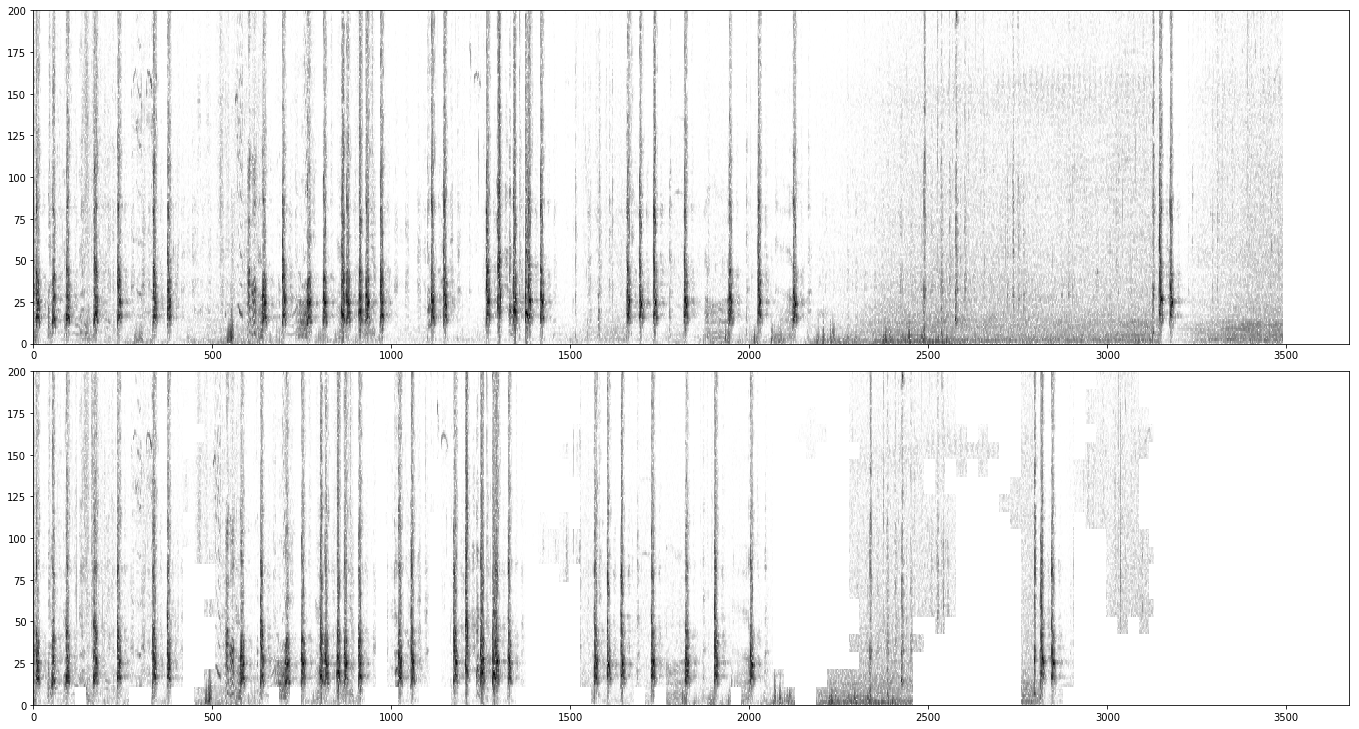

In [26]:
for data_item in data:
    print("Processing {}".format(data_item[1]['FileName']))
    print('  data_item[0]={}, len(data_item[0]={})'.format(data_item[0], len(data_item[0])))
    tempSpec, tempSpecFiltered = audioToFilteredSpectrogram(data_item[0])
    plt.ioff()
    fig = plt.figure(figsize=(19,10))
    ax1=plt.subplot(211)
    plt.tight_layout()
    plt.pcolormesh(tempSpec, cmap=plt.cm.binary)
    plt.subplot(212, sharex=ax1, sharey=ax1)
    plt.pcolormesh(tempSpecFiltered, cmap=plt.cm.binary)
    plt.show()
    plt.close(fig)

### The End!